In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import nltk
import sklearn
from transformers import pipeline

In [38]:
meta_cols = ['movie_id', 'title', 'year', 'rating', 'no. votes', 'genres']
meta = pd.read_table(
    './datasets/movie-dialog-corpus/movie_titles_metadata.tsv', sep='\t', header=None, names=meta_cols, index_col='movie_id')


In [3]:
meta.head()

,title,year,rating,no. votes,genres
movie_id,,,,,
m0,10 things i hate about you,1999,6.9,62847,['comedy' 'romance']
m1,1492: conquest of paradise,1992,6.2,10421,['adventure' 'biography' 'drama' 'history']
m2,15 minutes,2001,6.1,25854,['action' 'crime' 'drama' 'thriller']
m3,2001: a space odyssey,1968,8.4,163227,['adventure' 'mystery' 'sci-fi']
m4,48 hrs.,1982,6.9,22289,['action' 'comedy' 'crime' 'drama' 'thriller']


In [4]:
line_cols = ['line_id', 'character_id', 'movie_id', 'character_name', 'text']
lines = pd.read_table('./datasets/movie-dialog-corpus/movie_lines.tsv', sep='\t',
                      header=None, names=line_cols, index_col='line_id', on_bad_lines='skip')

conv_cols = ['first_char', 'second_char', 'movie_id', 'line_ids']
convos = pd.read_table(
    './datasets/movie-dialog-corpus/movie_conversations.tsv', sep='\t', header=None, names=conv_cols, on_bad_lines='skip')


In [5]:
def str_to_list(str: str):
    return str.strip('\'[]').split("\' \'")

meta.genres = meta.genres.apply(str_to_list)

In [6]:
import re

def preprocess_text(text):
    return re.sub('\x92', "'", re.sub('\x97', ' - ', re.sub('<.+>', ' ', text)))

lines = lines.dropna()
lines['text_pp'] = lines.text.apply(preprocess_text)

In [7]:
meta.explode('genres').genres.value_counts()

drama          320
thriller       269
action         168
comedy         162
crime          147
romance        132
sci-fi         120
adventure      116
mystery        102
horror          99
fantasy         78
biography       25
war             23
history         21
animation       18
family          17
music           13
western         12
musical          8
sport            8
short            5
film-noir        4
documentary      3
adult            1
                 1
Name: genres, dtype: int64

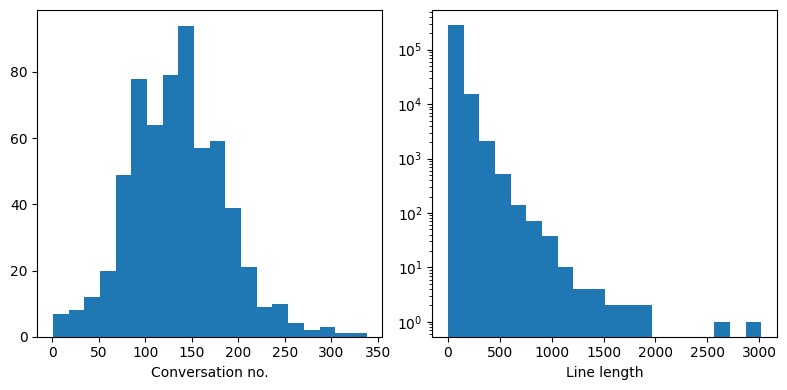

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(8,4), tight_layout=True)

axes[0].hist(convos.groupby('movie_id').count().line_ids, bins=20)
axes[0].set_xlabel('Conversation no.')

axes[1].hist(lines.text_pp.apply(len), bins=20)
axes[1].set_xlabel('Line length')
plt.yscale('log')

plt.show()

In [9]:
[np.nan]*11

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

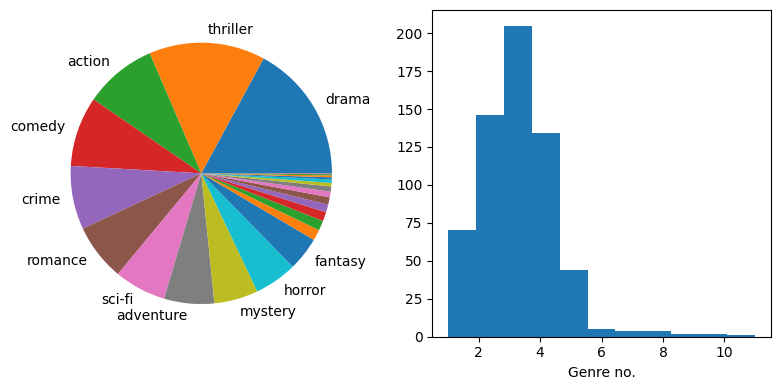

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(8,4), tight_layout=True)

genre_counts = meta.explode('genres').genres.value_counts()

labels = np.concatenate([genre_counts.index[:11],np.repeat('', len(genre_counts.index[11:]))])
axes[0].pie(genre_counts, labels=labels)

axes[1].hist(meta.genres.apply(len), bins=11)
axes[1].set_xlabel('Genre no.')


plt.show()

In [11]:
dialog_texts = pd.read_pickle('./data/dialog_texts')

In [12]:
dialog_texts.head()

,first_char,second_char,movie_id,text
0,u0,u2,m0,Can we make this quick? Roxanne Korrine and A...
1,u0,u2,m0,You're asking me out. That's so cute. What's ...
2,u0,u2,m0,No no it's my fault -- we didn't have a proper...
3,u0,u2,m0,Why? Unsolved mystery. She used to be really ...
4,u0,u2,m0,Gosh if only we could find Kat a boyfriend... ...


In [13]:
def movie_texts(movie_id) -> pd.Series:
    return dialog_texts[dialog_texts['movie_id'] == movie_id]['text']

In [14]:
meta[meta.genres.apply(lambda x : 'comedy' in x)].index

Index(['m0', 'm4', 'm12', 'm13', 'm22', 'm24', 'm27', 'm31', 'm35', 'm38',
       ...
       'm573', 'm575', 'm579', 'm595', 'm598', 'm600', 'm602', 'm605', 'm607',
       'm615'],
      dtype='object', name='movie_id', length=159)

In [ ]:
def genre_texts(genre, n):
    movies = meta[meta.genres.apply(lambda x: genre in x)].sample(n)
    return dialog_texts.join(movies, on="movie_id", how="inner")

genre_texts('comedy', 20)

In [ ]:
exploded_avg_emots = movie_avg_emots.join(meta, on="movie_id", how="inner").explode(
    'genre_list').drop(['title', 'year', 'genre_list'], axis=1)


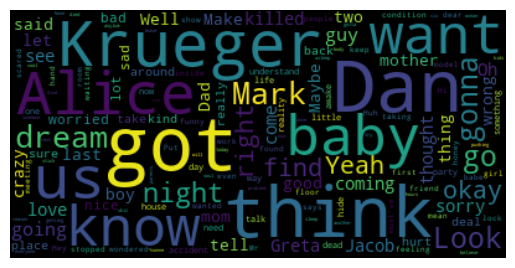

In [16]:
from wordcloud import WordCloud

wordcloud = WordCloud(max_font_size=60).generate(' '.join(movie_texts('m8'))) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

In [39]:
def str_to_list(str: str):
    s = str.strip('\'[]')
    return list(set(s.split("\' \'") if s else []))

meta['genre_list'] = meta.genres.apply(str_to_list)

In [35]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from lexical_diversity import lex_div as ld

def sample_genre(genre, n):
    return meta[meta.genre_list.apply(lambda x: genre in x)].sample(n)

STOP_WORDS = set(stopwords.words('english'))

def is_word(string: str):
    return string.isalpha() and string.lower() not in STOP_WORDS


def tokenize(text):
    return [w for w in word_tokenize(text) if is_word(w)]

def lexical_diversity(text):
    return ld.msttr(tokenize(text))

def chunk_texts(texts, n):
    

In [ ]:
def dispersion_plot(text, words, ax, ignore_case=True):
    text = list(text)
    words.reverse()

    if ignore_case:
        words_to_comp = list(map(str.lower, words))
        text_to_comp = list(map(str.lower, text))
    else:
        words_to_comp = words
        text_to_comp = text
    points = [
        (x, y)
        for x in range(len(text_to_comp))
        for y in range(len(words_to_comp))
        if text_to_comp[x] == words_to_comp[y]
    ]
    if points:
        x, y = list(zip(*points))
    else:
        x = y = ()
    ax.plot(x, y, "b|", scalex=0.1)
    plt.yticks(list(range(len(words))), words, color="b")
    plt.ylim(-1, len(words))
    plt.xlabel("Word Offset")


In [ ]:
words = ["bad", "good", "night", "day", "shit", "nice", "wow"]

plt.subplots(1, 3, figsize=(12, 3))

ax = plt.subplot(131)
dispersion_plot(comedy_text, words.copy(), ax)
ax.set_title("comedy")

ax = plt.subplot(132)
dispersion_plot(crime_text, words.copy(), ax)
ax.set_title("crime")

ax = plt.subplot(133)
dispersion_plot(horror_text, words.copy(), ax)
ax.set_title("horror")
plt.show()


In [ ]:
wordcloud = WordCloud(max_font_size=60).generate(' '.join(horror_text.tokens)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

In [ ]:
from nltk import FreqDist

plt.subplots(1, 3, figsize=(12, 3))
plt.subplot(131)
ax = FreqDist(comedy_text).plot(30, show=False)
ax.set_title("comedy")

plt.subplot(132)
ax = FreqDist(crime_text).plot(30, show=False)
ax.set_title("crime")

plt.subplot(133)
ax = FreqDist(horror_text).plot(30, show=False)
ax.set_title("horror")
plt.show()

In [ ]:
from lexical_diversity import lex_div as ld

def lexical_diversity(text):
    return ld.msttr(tokenize(text))

for mid, s in meta.sample(50, random_state=0).iterrows():
    text = ' '.join(lines[lines.movie_id == mid].text_pp.to_list())
    n = 5000
    min_l = 500
    text_chunks = [text[i:i+n] for i in range(0, len(text), n) if len(text) - i > min_l]
    data = [lexical_diversity(txt) for txt in text_chunks]
    plt.plot(np.arange(len(data)) * n, data, 'g-', alpha=0.2)

plt.xlabel('Word offset') 
plt.ylabel('Lexical diversity') 
# plt.ylim(0, 1)
plt.show()

In [ ]:
from nltk import FreqDist
FreqDist(txt).plot(50, percents=True)


0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 
0 Him. Him . . . This. This . . .


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


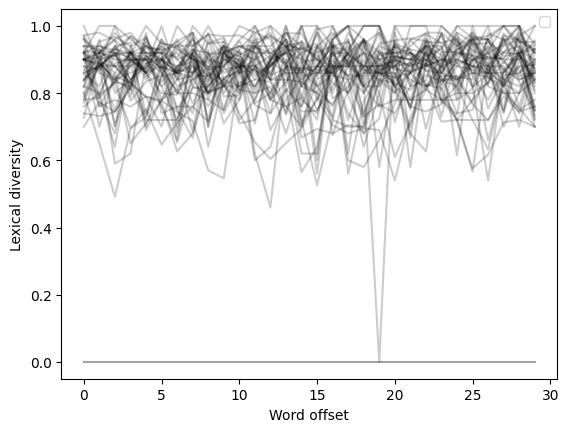

In [55]:
for mid, s in meta.sample(50).iterrows():
    texts = movie_texts(mid).to_list()
    strs = [' '.join(ts) for ts in np.array_split(texts, 30)]
    data = [lexical_diversity(s) for s in strs]
    for i, x in enumerate(data):
        if x < 0.3:
            print(x, strs[i])
    plt.plot(data, 'k-', alpha=.2)

plt.legend()
plt.xlabel('Word offset') 
plt.ylabel('Lexical diversity') 
# plt.ylim(0, 1)
plt.show()

In [ ]:
genre_texts('horror', 1)

In [20]:
from nltk.text import Text

tokens = tokenize(' '.join(genre_texts('crime', 20).text))

In [21]:
txt = Text(tokens)

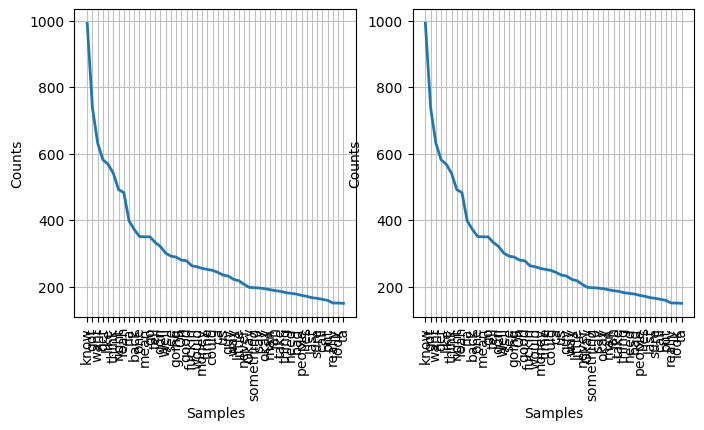

In [47]:
from nltk import FreqDist
plt.subplots(1, 2, figsize=(8, 4))
plt.subplot(1, 2, 1)
ax = FreqDist(txt).plot(50, show=False)
plt.subplot(1, 2, 2)
ax = FreqDist(txt).plot(50, show=False)
plt.show()
[].copy()


In [ ]:
txt.dispersion_plot()

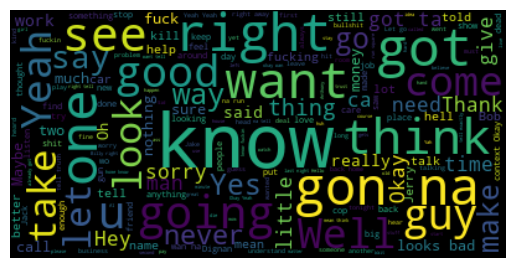

In [22]:
wordcloud = WordCloud(max_font_size=60).generate(' '.join(txt.tokens)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

In [43]:
txt.readability()

[('context', 'Okay'),
 ('looks', 'bad'),
 ('square', 'joint'),
 ('Ronnie', 'Billy'),
 ('taken', 'context'),
 ('control', 'Ronnie'),
 ('tell', 'truth'),
 ('run', 'square'),
 ('may', 'affected'),
 ('quiet', 'taken'),
 ('back', 'home'),
 ('crazy', 'lake'),
 ('boss', 'quiet'),
 ('memory', 'may'),
 ('Looks', 'bad'),
 ('bad', 'Looks'),
 ('exactly', 'happened'),
 ('lake', 'says'),
 ('thousand', 'dollars'),
 ('everything', 'nice')]

In [26]:
movie_texts('m0')

0      Can we make this quick?  Roxanne Korrine and A...
1      You're asking me out.  That's so cute. What's ...
2      No no it's my fault -- we didn't have a proper...
3      Why? Unsolved mystery.  She used to be really ...
4      Gosh if only we could find Kat a boyfriend... ...
                             ...                        
195    Would you rather be ravished by a pirate or a ...
196    They'll dance they'll kiss they'll come home. ...
197    What do you wanna watch?  We've got crap crap ...
198      Have a great time honey! But -- who -- what --?
199    What just happened? Your daughters went to the...
Name: text, Length: 200, dtype: object

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english")
X = vectorizer.fit_transform(movie_texts('m0'))
# vectorizer.get_feature_names_out()
vectorizer.get_feature_names_out()


array(['actually', 'ask', 'bianca', 'big', 'bogey', 'cameron',
       'completely', 'daddy', 'date', 'did', 'didn', 'does', 'doesn',
       'doing', 'don', 'dorsey', 'forget', 'girl', 'going', 'gonna',
       'good', 'got', 'guess', 'guy', 'guys', 'hate', 'heard', 'hell',
       'hey', 'hi', 'isn', 'joey', 'just', 'kat', 'know', 'let', 'like',
       'little', 'll', 'look', 'make', 'man', 'mean', 'mind', 'need',
       'night', 'oh', 'okay', 'party', 'patrick', 'people', 'prom',
       'really', 'right', 'say', 'school', 'sister', 'start', 'supposed',
       'sure', 'sweet', 'talk', 'tell', 'thing', 'think', 'thought',
       'time', 'told', 've', 'wanna', 'want', 'way', 'went', 'won',
       'yeah', 'year'], dtype=object)

In [33]:
X.

(200, 76)